In [32]:
import sys, os, math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
 
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *
 
print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.18.0.


In [2]:
ROOT_DIR = r"/Users/revathsankar/Documents/Adv Big AI/Midterm/Brain-MRI-Image-Classification-Using-Deep-Learning"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Brain-Tumor-Dataset")
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
MASK_DIR = os.path.join(DATA_ROOT_DIR, 'Tumor-Mask')
assert os.path.isdir(ROOT_DIR) and os.path.isdir(DATA_ROOT_DIR) and os.path.isdir(TRAIN_DIR) and os.path.isdir(MASK_DIR)
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor', 'no_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]
MASK_DATA_PATHS = [os.path.join(MASK_DIR, tumor_name) for tumor_name in TUMOR_CLASS[:-1]]

In [3]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = TUMOR_CLASS)
data_distribution_count.sum()

3459

### Dataset Visualization

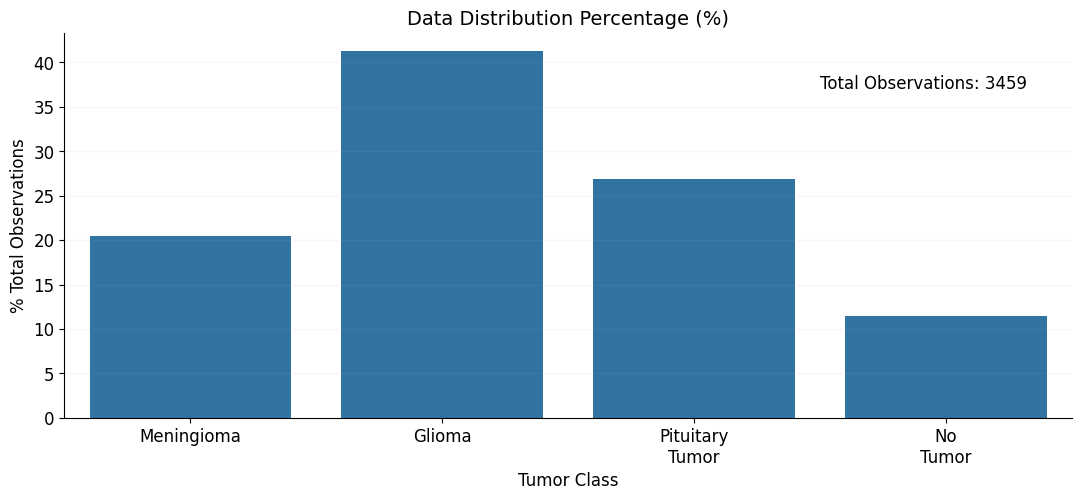

In [4]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index], 
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

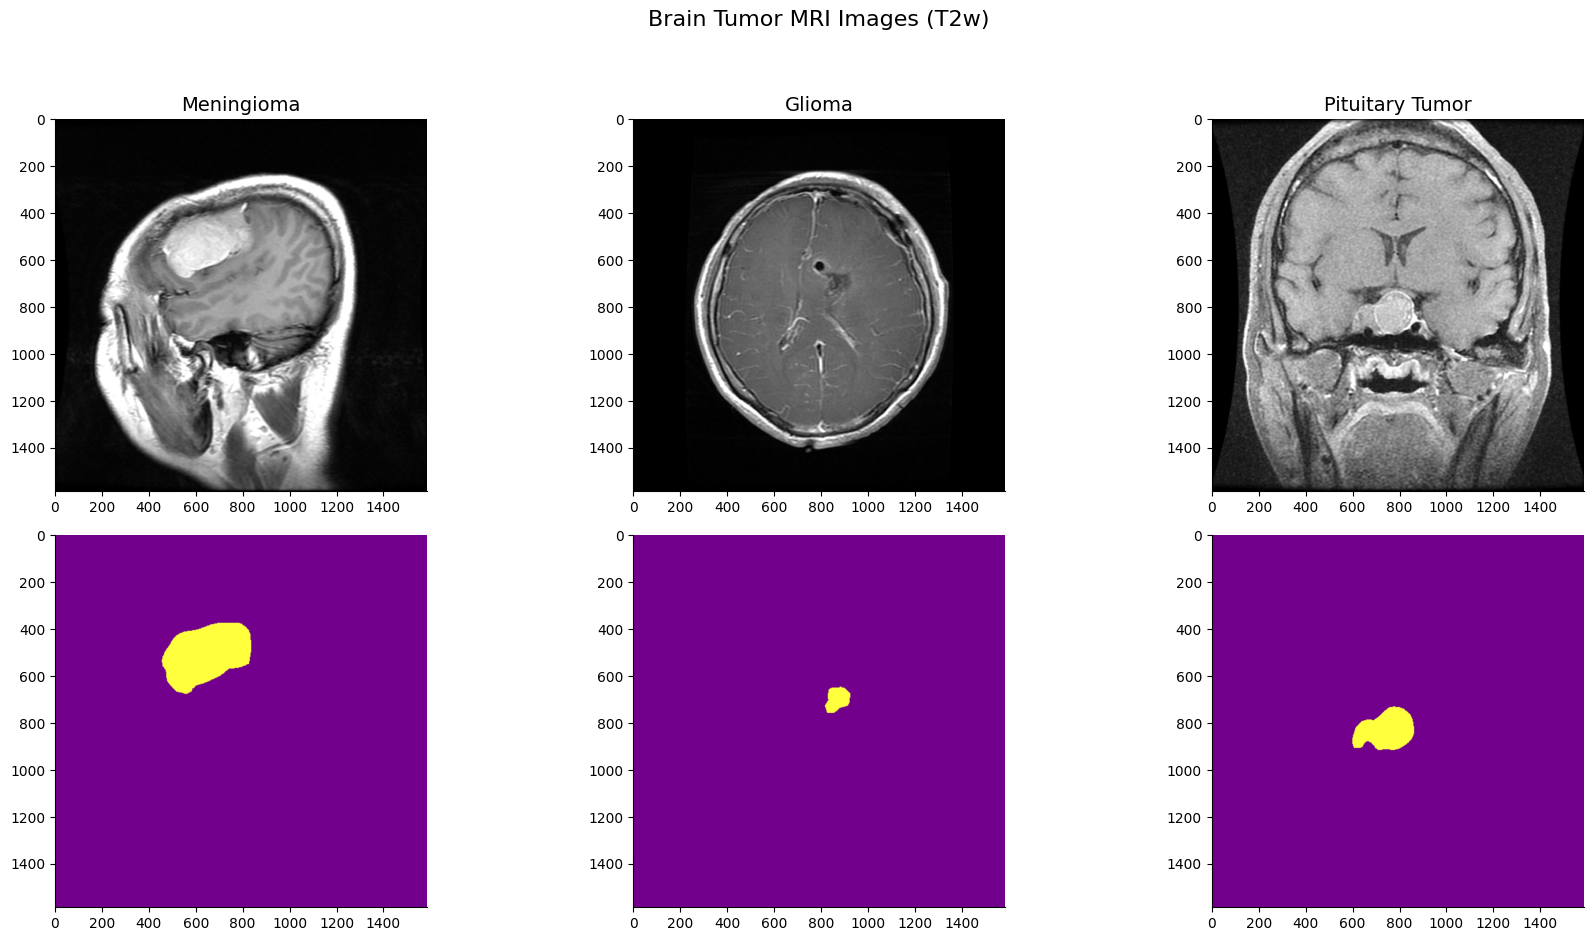

In [5]:
BRIGHTNESS_FACTOR = 1.7
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 9))
axes = axes.flatten()
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize = 16, fontdict = dict(fontweight = 'bold'), y = 1.04)
for curr_title, filename, curr_axis in zip(TUMOR_CLASS[:-1], IMAGE_DATA_PATHS[:-1], axes[:3]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR))
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)
 
for filename, curr_axis in zip(MASK_DATA_PATHS, axes[3:]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    mask_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(mask_enhancer.enhance(BRIGHTNESS_FACTOR))
fig.tight_layout()
sns.despine()

### Train/Test Development

In [6]:
image_data_paths = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

,image_filepaths,tumor_class
0,/Users/revathsankar/Documents/Adv Big AI/Midte...,meningioma
1,/Users/revathsankar/Documents/Adv Big AI/Midte...,meningioma
2,/Users/revathsankar/Documents/Adv Big AI/Midte...,pituitary_tumor
3,/Users/revathsankar/Documents/Adv Big AI/Midte...,pituitary_tumor
4,/Users/revathsankar/Documents/Adv Big AI/Midte...,pituitary_tumor


In [7]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df, 
                                                      train_size = 0.70, 
                                                      random_state = 42, 
                                                      stratify = image_data_paths_df.tumor_class)
 
train_data, validation_data = train_test_split(intermediate_train_data, 
                                               train_size = 0.80, 
                                               random_state = 42, 
                                               stratify = intermediate_train_data.tumor_class)

/var/folders/fw/67gglslx399czqx1xylngpt00000gn/T/ipykernel_37225/1245289562.py:7: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  curr_axis.grid(False, alpha = 0.1)
/var/folders/fw/67gglslx399czqx1xylngpt00000gn/T/ipykernel_37225/1245289562.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
/var/folders/fw/67gglslx399czqx1xylngpt00000gn/T/ipykernel_37225/1245289562.py:7: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  curr_axis.grid(False, alpha = 0.1)
/var/folders/fw/67gglslx399czqx1xylngpt00000gn/T/ipykernel_37225/1245289562.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  curr_axis.set_xticklabels(["

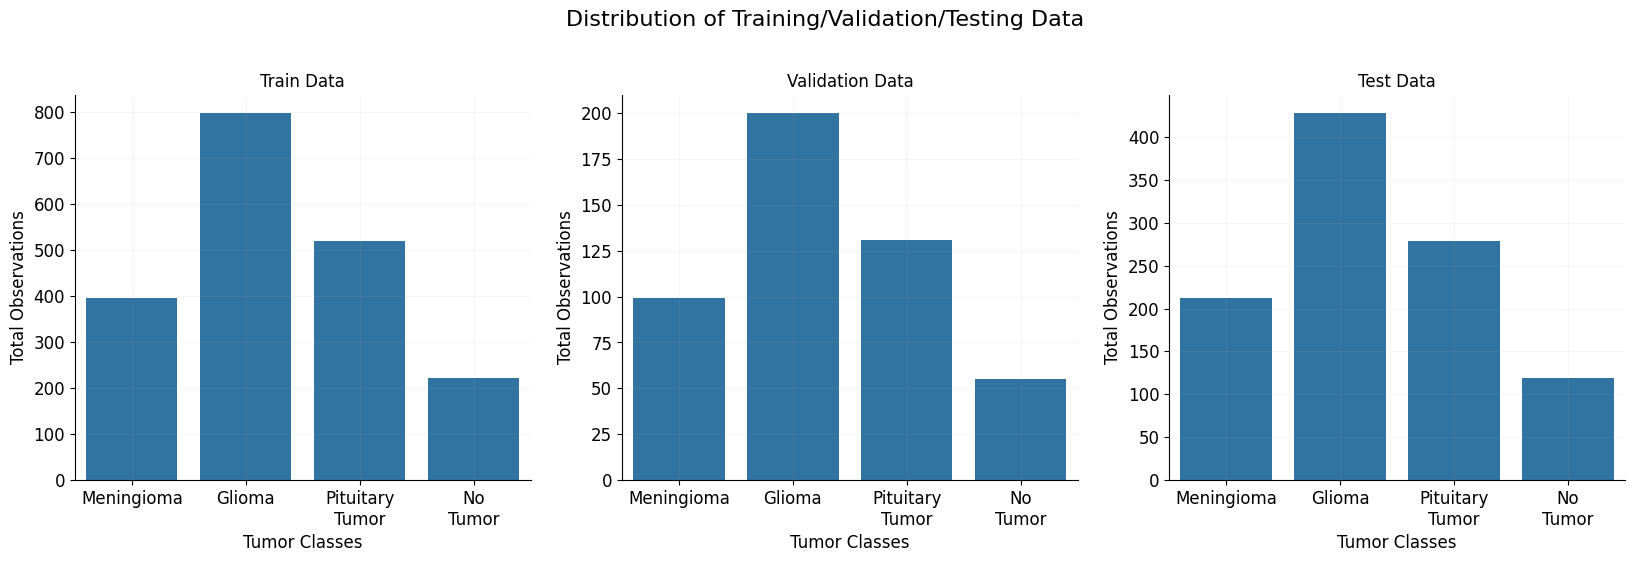

In [8]:
fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))
fig.suptitle("Distribution of Training/Validation/Testing Data", fontsize = 16, fontdict = dict(fontweight = 'bold'), y = 1.05)
sns.countplot(x = train_data.tumor_class, order = TUMOR_CLASS, ax = axes[0])
sns.countplot(x = validation_data.tumor_class, order = TUMOR_CLASS, ax = axes[1])
sns.countplot(x = test_data.tumor_class, order = TUMOR_CLASS, ax = axes[2])
for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data', 'Test Data']):
    curr_axis.grid(False, alpha = 0.1)
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("Tumor Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
sns.despine()

## 7 Data Augmentation

In [9]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15, 
                            width_shift_range = 0.1, 
                            zoom_range = 0.01, 
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [10]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [11]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data, 
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data, 
                                                                  x_col = 'image_filepaths', 
                                                                  y_col = 'tumor_class', 
                                                                  seed = 42,
                                                                  batch_size = batch_size, 
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data, 
                                                      x_col = 'image_filepaths', 
                                                      y_col = 'tumor_class', 
                                                      seed = 42, 
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 1936 validated image filenames belonging to 4 classes.
Found 485 validated image filenames belonging to 4 classes.
Found 1038 validated image filenames belonging to 4 classes.


In [12]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')
 
print("Information about Validation Dataset:")
print(validation_dataset.class_indices)
print(validation_dataset.image_shape, end = '\n\n')
 
print("Information about Testing Dataset:")
print(test_dataset.class_indices)
print(test_dataset.image_shape)

Information about Training Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Validation Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Testing Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)


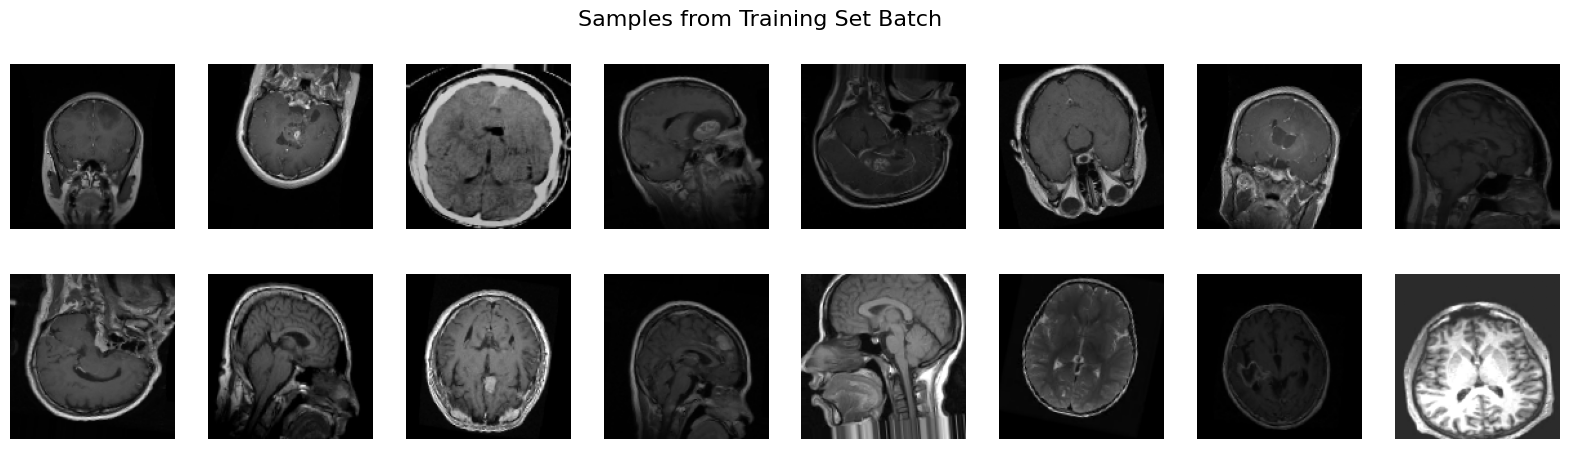

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize = 16, fontdict = dict(fontweight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), train_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

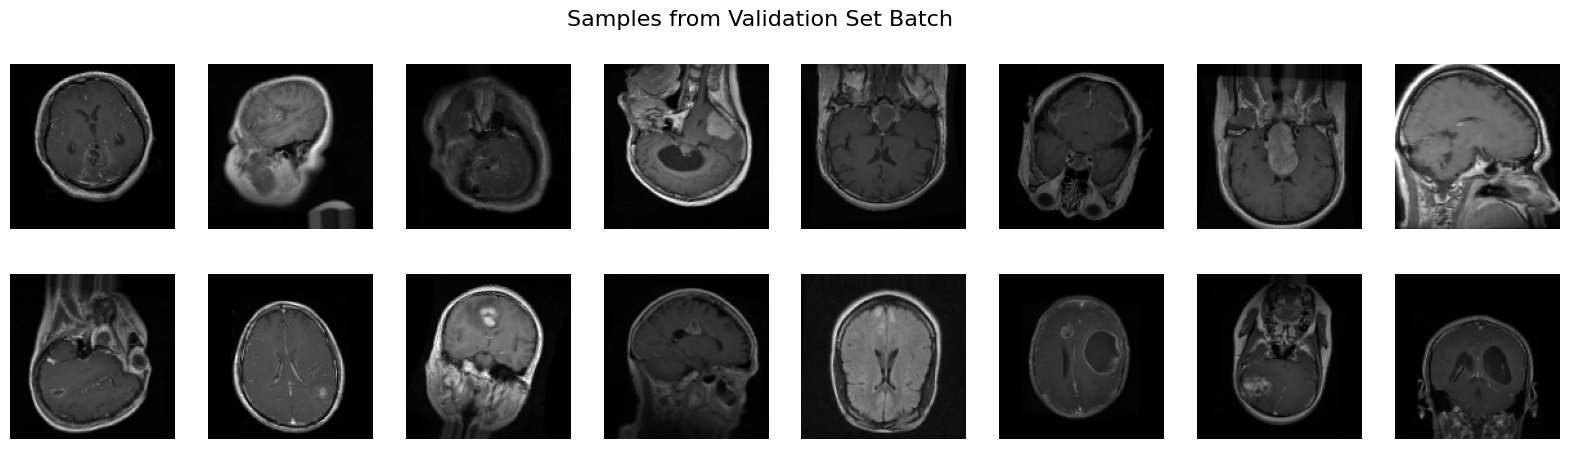

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize = 16, fontdict = dict(fontweight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

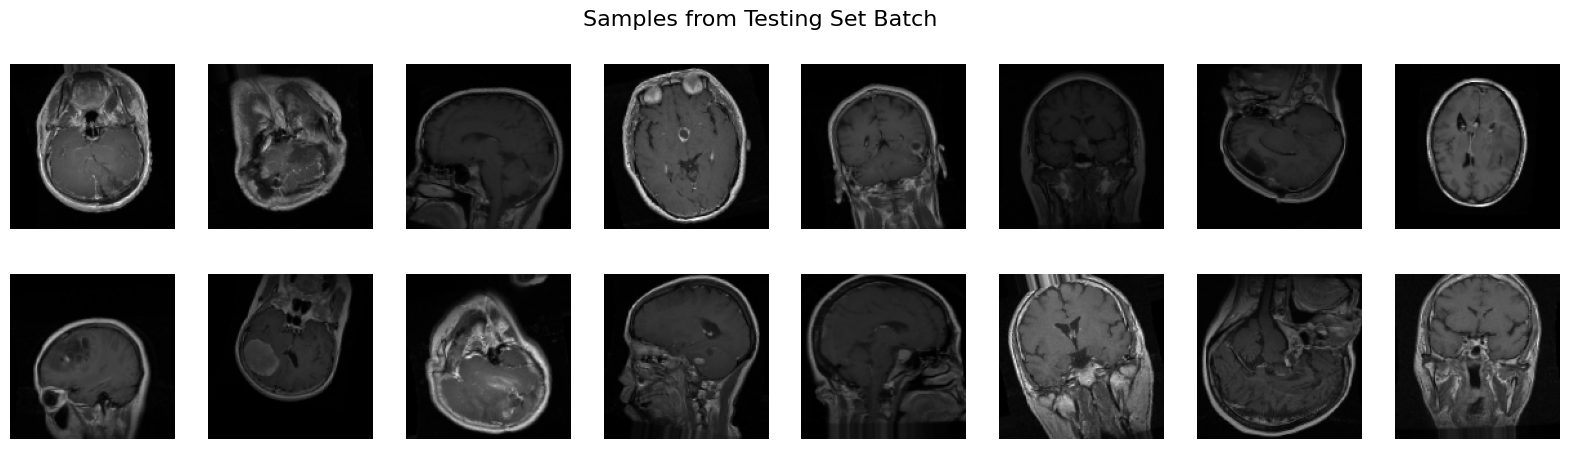

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontdict = dict(fontweight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

## InceptionV3 Model

In [16]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [17]:
ROOT_CHECKPOINT_DIR_PATH = os.path.join(ROOT_DIR, "Model-Checkpoints")
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")
# assert os.path.isdir(ROOT_CHECKPOINT_DIR_PATH) and os.path.isdir(MLP_CHECKPOINT_DIR_PATH) and os.path.isdir(ALEXNET_CHECKPOINT_DIR_PATH) and os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH)

In [18]:
INCEPTIONV3_CHECKPOINT_DIR_PATH_WEIGHTS = os.path.join(INCEPTIONV3_CHECKPOINT_DIR_PATH, "advbig_model.weights.h5")

inceptionv3_cp_callback = ModelCheckpoint(INCEPTIONV3_CHECKPOINT_DIR_PATH_WEIGHTS, 
                                          monitor = 'val_accuracy', 
                                          verbose = 1, 
                                          save_weights_only = True, 
                                          save_freq = 'epoch')

In [35]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['title'], fontsize = 16, fontdict = dict(fontweight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

In [20]:
def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize = (8, 6))
    class_names = ['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary\nTumor']
    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), annot = True, cmap = plt.cm.Reds, ax = axis)
    axis.set_title(plot_kwargs['plot_title'], fontsize = 14)
    axis.tick_params(which = 'major', labelsize = 12)
    axis.set_xlabel("Pedicted Class", fontsize = 12)
    axis.set_ylabel("Actual Class", fontsize = 12)
    axis.set_xticklabels(class_names, fontdict = dict(fontsize = 12))
    axis.set_yticklabels(class_names, fontdict = dict(fontsize = 12))
    fig.tight_layout()
    sns.despine()

In [21]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [mean_absolute_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds), root_mean_squared_error(y_hat, y_preds), curr_model_loss, curr_model_accuracy, f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

In [22]:
inception_v3_model = InceptionV3(include_top = False, 
                                 input_shape = (image_size, image_size, 3), 
                                 pooling = 'avg')
inception_v3_model.trainable = False

In [23]:
inception_cnn_model = Sequential()
inception_cnn_model.add(inception_v3_model)
inception_cnn_model.add(Flatten())
inception_cnn_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
inception_cnn_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
inception_cnn_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
inception_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden-Layer-1 (Dense)          │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [24]:
# with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
inception_model_train_history = inception_cnn_model.fit(train_dataset, 
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset, 
                                                            epochs = 100, 
                                                            callbacks = [early_stopping, inceptionv3_cp_callback])

/Users/revathsankar/Documents/Adv Big AI/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.4787 - loss: 4.2517
Epoch 1: saving model to /Users/revathsankar/Documents/Adv Big AI/Midterm/Brain-MRI-Image-Classification-Using-Deep-Learning/Model-Checkpoints/InceptionV3/advbig_model.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.4806 - loss: 4.2170 - val_accuracy: 0.6742 - val_loss: 0.9213
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7173 - loss: 0.7188
Epoch 2: saving model to /Users/revathsankar/Documents/Adv Big AI/Midterm/Brain-MRI-Image-Classification-Using-Deep-Learning/Model-Checkpoints/InceptionV3/advbig_model.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - accuracy: 0.7175 - loss: 0.7183 - val_accuracy: 0.7835 - val_loss: 0.5877
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7909 - loss: 0.5317
Epoch 3: saving model to /Users/revathsankar/Documents/Adv Big AI/Midterm/Brain-MRI-Image-Classification-Using-Deep-Learning/Model-Checkpoints/In

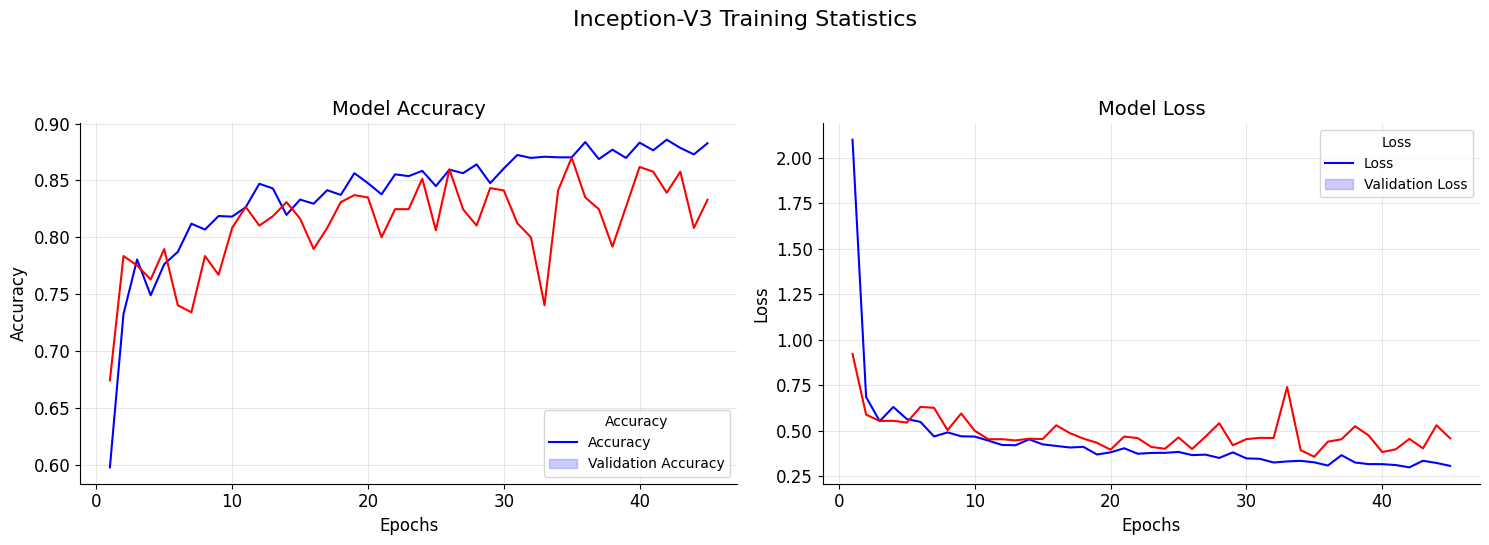

In [25]:
training_process_viz(pd.DataFrame(inception_model_train_history.history), 
                     plot_title = 'Inception-V3 Training Statistics')

In [30]:
# with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
inception_model_test_history = inception_cnn_model.fit(test_dataset, 
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset, 
                                                            epochs = 100, 
                                                            callbacks = [early_stopping, inceptionv3_cp_callback])

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8255 - loss: 0.4934
Epoch 1: saving model to /Users/revathsankar/Documents/Adv Big AI/Midterm/Brain-MRI-Image-Classification-Using-Deep-Learning/Model-Checkpoints/InceptionV3/advbig_model.weights.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - accuracy: 0.8253 - loss: 0.4940 - val_accuracy: 0.7979 - val_loss: 0.5103
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8231 - loss: 0.4458
Epoch 2: saving model to /Users/revathsankar/Documents/Adv Big AI/Midterm/Brain-MRI-Image-Classification-Using-Deep-Learning/Model-Checkpoints/InceptionV3/advbig_model.weights.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.8234 - loss: 0.4457 - val_accuracy: 0.8041 - val_loss: 0.4737
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8335 - loss: 0.5046
Epoch 3: saving model to /Users/revathsankar/Documents/Adv Big AI/Midterm/Brain-MRI-Image-Classification-Using-Deep-Learning/Model-Checkpoints/Inc

/Users/revathsankar/Documents/Adv Big AI/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step


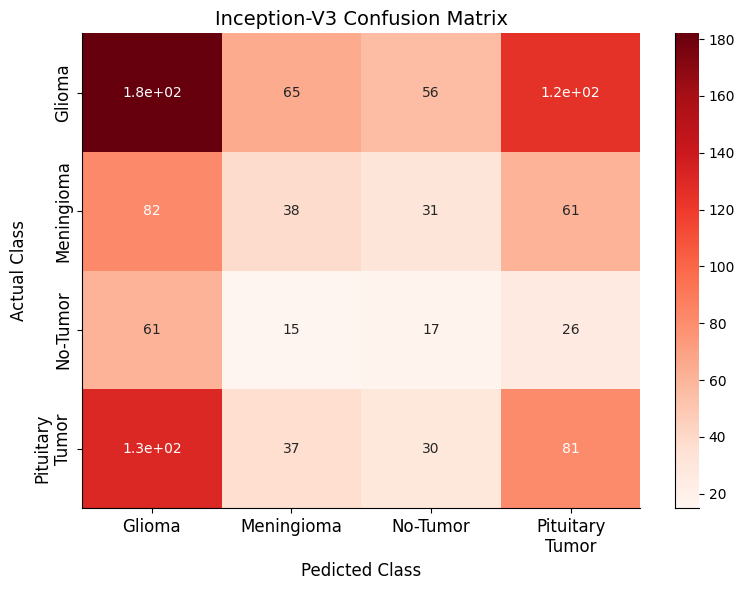

In [26]:
# with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_name):
confusion_matrix_viz(inception_cnn_model, 
                         test_dataset, 
                         plot_title = "Inception-V3 Confusion Matrix")

In [27]:
inceptionv3_report_df = generate_report(inception_cnn_model, test_dataset = test_dataset, row_indexes = ['InceptionV3'])
inceptionv3_report_df

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.8364 - loss: 0.4804
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
InceptionV3,1.421002,3.328516,1.824422,0.450645,0.845857,0.2842


### Export Model Weights

In [28]:
import pickle

with open("adv_big_weights.pkl", "wb") as model_file:
    pickle.dump(inception_cnn_model, model_file,)
